## NLTK 

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import pandas as pd
import stock_data
import validation 
import sklearn.preprocessing as preprocessing 
import matplotlib.pyplot as plt

def collapse_articles(data_source = "./willsu/nyt_1800.pkl", stockName = "GOOG", 
                      time_before = '2018-09-27', time_after = '2019-05-17'):
    """
    Loads the pkl file collected from NY Times API and label each day's worth of articles
    to the next day's stock growth. 
    Weekends are skipped and handled.
    Holidays are also handled.
    
    Params: 
        time_before and time_after specify the dates to truncate the data to
    """
    #Open and load the data
    with open(data_source, "rb") as fp:   
        raw = pickle.load(fp)
    
    #------------------ Prepare Initial DataFrame ---------------
    #Prepare DataFrame.
    df = pd.DataFrame(raw, columns = ["link", "time", "words"])
    df['time'] = pd.to_datetime(df.time)
    df = df.sort_values('time').set_index('time')
    
    #Collapse weekends onto Friday
    df['dayofweek'] = df.index.dayofweek
    df.loc[df.dayofweek == 5,  'index'] = df[df.dayofweek == 5].index - pd.Timedelta(days=1)
    df.loc[df.dayofweek == 6, 'index'] = df[df.dayofweek == 6].index - pd.Timedelta(days=2)
    df.loc[(df.dayofweek != 5) & (df.dayofweek != 6),  'index'] = df[(df.dayofweek != 5) & (df.dayofweek != 6)].index
    df.drop(columns = ['link', 'index'], inplace = True)
    
    #Convert to string to get rid of none types
#     df['liststring'] = [','.join(map(str, l)).lower() if l is not None else "" for l in df['words'] ]
    df['liststring'] = [','.join(map(str, l)) if l is not None else "" for l in df['words'] ]
    
    df.drop(columns= ['words'], inplace = True)
    df = df.groupby(pd.Grouper(freq='D'))['liststring'].apply(lambda x: x.sum())
    
    #------------------- Grab Stock Data-----------------------
    #Get Stock and truncate some of the time to fit time frame.
    label = stock_data.get_stock_data(stockName, '94Z49Z19XNL1GGGP') #Note that this is an API Key
    label = label.truncate(before=pd.Timestamp(time_before), after=pd.Timestamp(time_after))
    
    #Only use "Open" as our label.
    label['dayofweek'] = label.index.dayofweek
    label.drop(columns=['high', 'low', 'close', 'volume', 'ds'], inplace=True)
    
    # Shift dates back by 1 day, stored into column "last"
    # Handle the unique case of Monday where the delta will be taken from Friday. Not Sunday.
    label.loc[label.dayofweek == 0, 'prev_date'] = label[label.dayofweek == 0].index - pd.Timedelta(days=3)
    label.loc[label.dayofweek != 0, 'prev_date'] = label[label.dayofweek != 0].index - pd.Timedelta(days=1)
    
    #------------------- Grab Labels of Each Day -----------------------
    deltas = label.merge(label, left_on='prev_date', right_on='date', suffixes=('_left', '_right'))
    deltas.rename({'open_left':'date'}, inplace=True)
    deltas.set_index('prev_date_left', drop=True, inplace=True)
    deltas['delta'] = pd.to_numeric(deltas.open_left) - pd.to_numeric(deltas.open_right)
    deltas.drop(columns=['open_left', 'open_right', 'prev_date_right', 'dayofweek_left', 'dayofweek_right'], inplace=True)
    deltas.index.set_names(['time'], inplace=True)
    
    #------------------- Join Initial DataFrame and Labels -----------------------
    final_df = pd.DataFrame(df) 
    final_df.index = pd.to_datetime(final_df.index)
    
    #Handle weekends 
    final_df['dayofweek'] = final_df.index.dayofweek
    final_df = final_df[final_df.dayofweek != 5]
    final_df = final_df[final_df.dayofweek != 6]

    #Append delta
    final_df = pd.merge(final_df, deltas, on = 'time', how = 'inner').drop(columns = 'dayofweek')
    
    return final_df
    
def get_nltk_sentiment(words):
    """
    Calls NLTK's sentiment analyzer to get the polarity scores of words.
    """
    sid = SentimentIntensityAnalyzer()
    cc = sid.polarity_scores(words)
    return (cc['compound'])

def get_sentiments(data):
    """
    Function that gets score for text using both our own rule based bag-of-words and NLTK's model.
    The returned value should be of a dataframe of columns:
        date, liststring (all the words), delta(change in stock), rule_score, nltk_compund
    """
    data['rule_score'] = data['liststring'].map(lambda x : validation.get_rule_sentiment(x.lower().split(',')))
    data['nltk_compound'] = data['liststring'].map(lambda x : get_nltk_sentiment(x.replace(',', ' ')))
    return data

def plot_data(data, normFunc, start, end, nltk):
    """
    Plot the data as specified by the normalizer function.
    Params:
        start & end specify how much data to display. The default is all
    """
    if (normFunc == "min-max"):
        scale = preprocessing.MinMaxScaler()
        print('Min Max')
    elif (normFunc == "quant"):
        scale = preprocessing.QuantileTransformer(n_quantiles=10, random_state=0)
        print('Quant')
    else:
        scale = preprocessing.StandardScaler()
        print('StandardScale: z = (x - u) / s')
        
    data = data[start:end]
    
    X = data.drop(columns = "liststring")    
    x_scale = pd.DataFrame(scale.fit_transform(X.values))
    x_scale.rename(columns = {0: "stock", 1: "rule_score", 2: 'nltk'}, inplace= True)
    
    #Drop nltk
    if (not nltk):
        x_scale.drop(columns = 'nltk', inplace = True)
    
    #Set time index back
    x_scale['date'] = X.index
    x_scale.set_index('date', inplace = True)
    
    return x_scale.plot(figsize=(10, 5))

In [102]:
data = collapse_articles(data_source = "./willsu/nyt_1800.pkl", stockName = "GOOG", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
data.head()

,liststring,delta
time,,
2018-09-27,"MANCHESTER,England,It,was,past,midnight,when,J...",5.14
2018-09-28,"You,may,have,noticed,a,bold,advertisement,in,T...",8.02
2018-10-01,"A,new,sitcom,airs,on,CBS,while,a,new,documenta...",-8.93
2018-10-02,"Student,Athlete,a,documentary,with,LeBron,Jame...",14.04
2018-10-03,"Apple,opened,a,routine,product,launch,event,la...",-9.67


In [17]:
data = get_sentiments(data)
data.head()

,liststring,delta,rule_score,nltk_compound
time,,,,
2018-09-27,"manchester,england,it,was,past,midnight,when,j...",5.14,430,0.9998
2018-09-28,"you,may,have,noticed,a,bold,advertisement,in,t...",8.02,401,0.9999
2018-10-01,"a,new,sitcom,airs,on,cbs,while,a,new,documenta...",-8.93,76,0.9986
2018-10-02,"student,athlete,a,documentary,with,lebron,jame...",14.04,249,0.9998
2018-10-03,"apple,opened,a,routine,product,launch,event,la...",-9.67,283,0.9999


Min Max


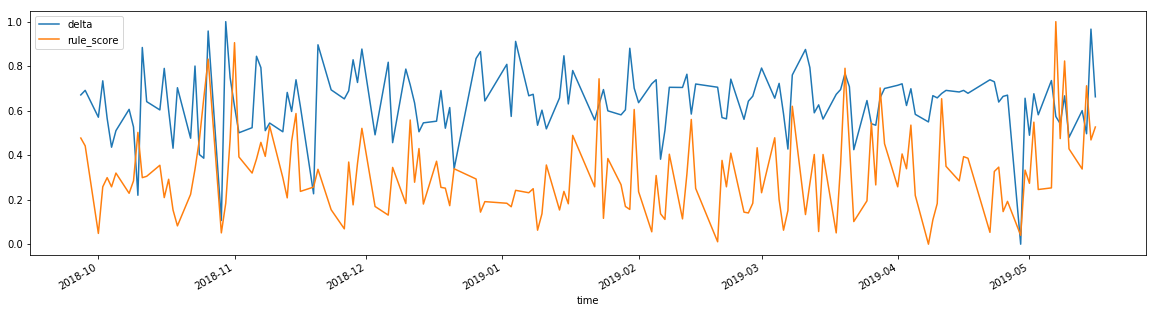

Quant


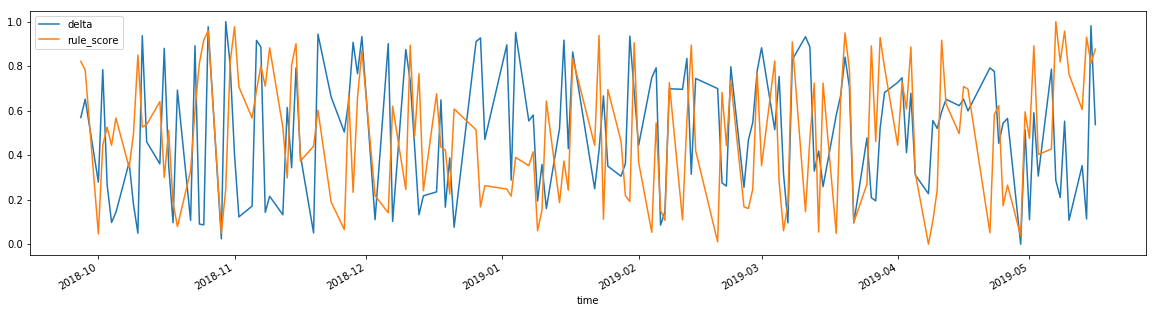

StandardScale


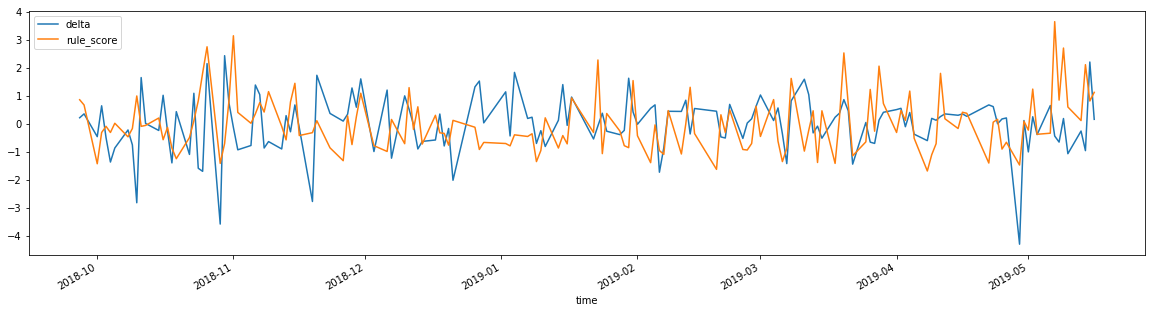

In [18]:
plot_data(data, "min-max", 0, data['delta'].count(), False)
plot_data(data, "quant", 0, data['delta'].count(), False)
plot_data(data, "std", 0, data['delta'].count(), False)

StandardScale: z = (x - u) / s


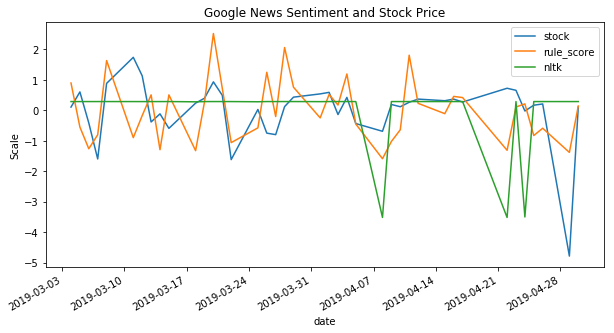

In [56]:
sth = plot_data(data, normFunc = "std", start = 100, end = 140 , nltk = True)
plt.title("Google News Sentiment and Stock Price")
plt.ylabel("Scale")
plt.show()

In [7]:
data2 = collapse_articles(data_source = "./willsu/apple-data.pkl", stockName = "AAPL", 
                      time_before = '2018-09-27', time_after = '2019-05-17')

In [10]:
data2 = get_sentiments(data2)

StandardScale: z = (x - u) / s


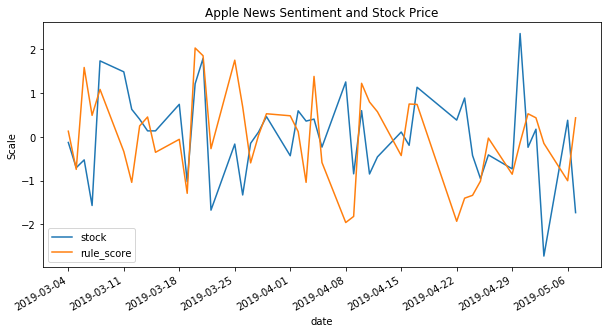

In [28]:
plot_data(data2, "std", 100, 145 , False)
plt.title("Apple News Sentiment and Stock Price")
plt.ylabel("Scale")
plt.show()